In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sys
import os
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
if os.path.abspath('../../tt_keras') not in sys.path:
    sys.path.append(os.path.abspath('../../tt_keras'))

if os.path.abspath('../../t3f') not in sys.path:
    sys.path.append(os.path.abspath('../../t3f'))

import automatic_speech_recognition as asr
from automatic_speech_recognition.utils.graph_utils import fixate_rnn_shape
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

os.environ['PATH'] += ':/gpfs/gpfs0/r.schutski/'

# Testing utilities

In [2]:
from glob import glob
import json
from tflite_device_profile import (check_device, run_on_device, parse_profiler_output, batch_profile)
from tflite_device_profile import DEFAULT_PROF_CONFIG as config
from h5_to_tflite import (export_model, batch_export)

In [39]:
os.environ['ANDROID_ADB_SERVER_PORT'] = '5039'  # select which ADB to use. 5037 - local, 5038 - remote

check_device(True, adb_cmd='adb-1.0.39')

# Turn off phone's gpu usage, it can't handle anything
config['use_gpu'] = False
config['num_threads'] = 4
config['enable_op_profiling'] = False
config['num_runs'] = 1000
cpu_affinity = [0, 1, 2, 3]

Found device: AEJ0117C11000167


# Test original deepspeech

In [4]:
deepspeech = asr.model.load_mozilla_deepspeech('./data/myfrozen.pb', verbose=False)
fixate_rnn_shape(deepspeech, 1).save(f'./models/mozilla_deepspeech_tfliteready.h5')
export_model(f'./models/mozilla_deepspeech_tfliteready.h5', f'./tflite_models/mozilla_deepspeech.tflite', run_tests=True)

load graph
Instructions for updating:
Use tf.gfile.GFile.
converting: ./models/mozilla_deepspeech_tfliteready.h5 => ./tflite_models/mozilla_deepspeech.tflite


In [40]:
# profile reference model
ref_res = run_on_device('./tflite_models/mozilla_deepspeech.tflite', 
                        prof_config=config, 
                        cpu_affinity=cpu_affinity)
ref_result = parse_profiler_output(ref_res, is_file=False)
ref_result

ref_time = float(ref_result['main']['avg'])
ref_std = float(ref_result['main']['std'])

print(f"Reference time {ref_time} +- {ref_std}")

Reference time 43391.9 +- 9756.0


# Convert maxvol models to tflite

In [6]:
for filename in os.listdir('./models'):
    if 'maxvolled' in filename and 'tfliteready' not in filename:
        name = filename.split('.')[0]
        # skip if already cnverted to save time
        if os.path.exists(f'./tflite_models/{name}.tflite'):
            continue
        # fixate shape
        print(f"Start fixating {name}")
        fixate_rnn_shape(keras.models.load_model(f'./models/{name}.h5'), 1).save(f'./models/{name}_tfliteready.h5')
        # export dense model
        export_model(f'./models/{name}_tfliteready.h5', f'./tflite_models/{name}.tflite', run_tests=True)

Start fixating desnse4_2vol_maxvolled_deepspeech_r700


converting: ./models/desnse4_2vol_maxvolled_deepspeech_r700_tfliteready.h5 => ./tflite_models/desnse4_2vol_maxvolled_deepspeech_r700.tflite


Start fixating desnse4_2vol_maxvolled_deepspeech_r1500


converting: ./models/desnse4_2vol_maxvolled_deepspeech_r1500_tfliteready.h5 => ./tflite_models/desnse4_2vol_maxvolled_deepspeech_r1500.tflite


Start fixating desnse4_2vol_maxvolled_deepspeech_r100


converting: ./models/desnse4_2vol_maxvolled_deepspeech_r100_tfliteready.h5 => ./tflite_models/desnse4_2vol_maxvolled_deepspeech_r100.tflite


Start fixating desnse4_2vol_maxvolled_deepspeech_r500


converting: ./models/desnse4_2vol_maxvolled_deepspeech_r500_tfliteready.h5 => ./tflite_models/desnse4_2vol_maxvolled_deepspeech_r500.tflite


Start fixating desnse4_2vol_maxvolled_deepspeech_r1400


converting: ./models/desnse4_2vol_maxvolled_deepspeech_r1400_tfliteready.h5 => ./tflite_models/desnse4_2vol_maxvolled_deepspeech_r1400.tflite


Start fixating desnse4_2vol_maxvolled_deepspeech_r1700


converting: ./models/desnse4_2vol_maxvolled_deepspeech_r1700_tfliteready.h5 => ./tflite_models/desnse4_2vol_maxvolled_deepspeech_r1700.tflite


Start fixating desnse4_2vol_maxvolled_deepspeech_r1000


converting: ./models/desnse4_2vol_maxvolled_deepspeech_r1000_tfliteready.h5 => ./tflite_models/desnse4_2vol_maxvolled_deepspeech_r1000.tflite


Start fixating desnse4_2vol_maxvolled_deepspeech_r300


converting: ./models/desnse4_2vol_maxvolled_deepspeech_r300_tfliteready.h5 => ./tflite_models/desnse4_2vol_maxvolled_deepspeech_r300.tflite


Start fixating desnse4_2vol_maxvolled_deepspeech_r1200


converting: ./models/desnse4_2vol_maxvolled_deepspeech_r1200_tfliteready.h5 => ./tflite_models/desnse4_2vol_maxvolled_deepspeech_r1200.tflite


In [7]:
test_results = {}
for filename in os.listdir('./tflite_models'):
    if 'maxvolled' in filename:
        name = filename.split('.')[0]
        print(f"Profiling {name}")
        # profile model
        res = run_on_device(f'./tflite_models/{name}.tflite', 
                                prof_config=config, 
                                cpu_affinity=cpu_affinity)
        result = parse_profiler_output(res, is_file=False)
        time = float(result['main']['avg'])
        std = float(result['main']['std'])

        print(f"Time for {name} is {time} +- {std}")
        test_results[name] = (time, std)

Profiling desnse2_2vol_maxvolled_deepspeech_r100
Reference time for desnse2_2vol_maxvolled_deepspeech_r100 is 33716.7 +- 7343.0
Profiling desnse3_1vol_maxvolled_deepspeech_r1000
Reference time for desnse3_1vol_maxvolled_deepspeech_r1000 is 27235.5 +- 2073.0
Profiling lstm_1vol_maxvolled_deepspeech_r1400
Reference time for lstm_1vol_maxvolled_deepspeech_r1400 is 31308.1 +- 4431.0
Profiling lstm_desnse234_2vol_maxvolled_deepspeech_r500
Reference time for lstm_desnse234_2vol_maxvolled_deepspeech_r500 is 12622.8 +- 2891.0
Profiling desnse3_2vol_maxvolled_deepspeech_r700
Reference time for desnse3_2vol_maxvolled_deepspeech_r700 is 36220.6 +- 5503.0
Profiling lstm_2vol_maxvolled_deepspeech_r500
Reference time for lstm_2vol_maxvolled_deepspeech_r500 is 24382.6 +- 4473.0
Profiling desnse4_2vol_maxvolled_deepspeech_r1400
Reference time for desnse4_2vol_maxvolled_deepspeech_r1400 is 39097.4 +- 8255.0
Profiling lstm_1vol_maxvolled_deepspeech_r100
Reference time for lstm_1vol_maxvolled_deepspeech_

In [11]:
def get_run_rank(name):
    return int(name[name.index('_r') + 2:])

def get_run_name(name):
    return name[:name.index('_2vol_maxvolled')]

def is_full_change(name):
    return name.startswith('lstm_desnse234_2vol')

In [12]:
full_change_ranks = []
full_change_avg = []
full_change_std = []
for result_name, result_data in test_results.items():
    if is_full_change(result_name):
        full_change_ranks.append(get_run_rank(result_name))
        full_change_avg.append(result_data[0])
        full_change_std.append(result_data[1])
        
full_change_avg = np.array(full_change_avg)
full_change_std = np.array(full_change_std)

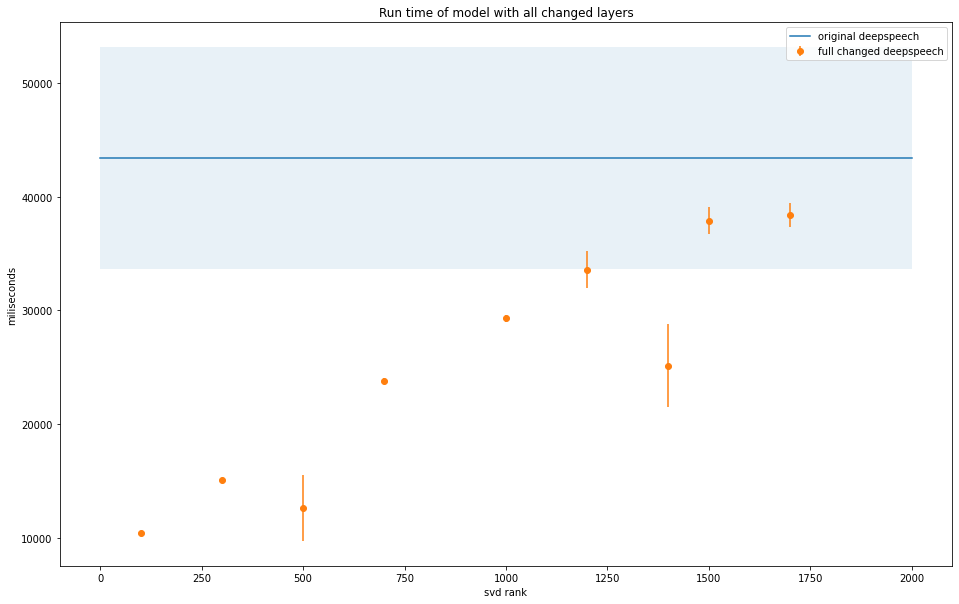

In [41]:
plt.figure(figsize=(16, 10))
plt.title('Run time of model with all changed layers')
plt.xlabel('svd rank')
plt.ylabel('miliseconds')
plt.plot([0, 2000], [ref_time, ref_time], label='original deepspeech')
plt.fill_between([0, 2000], [ref_time - ref_std, ref_time - ref_std], [ref_time + ref_std, ref_time + ref_std], alpha=0.1)
plt.errorbar(full_change_ranks, full_change_avg, yerr=full_change_std, fmt='o',label='full changed deepspeech')
# plt.fill_between([0, 2000], full_change_avg + full_change_std, full_change_avg - full_change_std)
plt.legend()